In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import sqlalchemy as db
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

np.seterr(divide = 'ignore')
pd.set_option('display.max_rows', 500)

In [2]:
load_dotenv()

# config and credentials
server = os.getenv('server')
database = os.getenv('database')
username = os.getenv('username')
password = os.getenv('password')

# connection
engine = db.create_engine(
    'mssql://{}:{}@{}/{}?driver=ODBC+Driver+18+for+SQL+Server'.format(
        username, password, server, database
    )
)

# establish connection
connection = engine.connect()

In [3]:
def get_sample_particulars(df):
    print('Number of observations: {:,}'.format(len(df.index)))
    print('Returns: Mean: {:.5f} | Median: {:.5f} | Std returns: {:.5f}'.format(
        100 * df['R'].mean(), 100 * df['R'].median(), df['R'].std()))
    print('Volume mean: {:.5f}'.format(df['TDvolume'].mean()))
    print('Coupon mean: {:.5f}'.format(df['Coupon'].mean()))

### Query Selection

In [4]:
volume = 100000

query = '''
    SELECT
        CusipId AS Cusip,
        TrdExctnDt AS Date,
        EntrdVolQt AS TDvolume,
        Coupon,
        R
    FROM 
        BondReturns_volumeGroups
    WHERE
        EntrdVolQt = {}
'''.format(
    volume
)

# read sql
# df = pd.read_sql(query, connection)
# df.to_csv('data/output/bonds/volume_groups-{}.csv'.format(volume), index=False)

# read csv
df = pd.read_csv('data/output/bonds/volume_groups-{}.csv'.format(volume))
df['Date'] = pd.to_datetime(df['Date'])

### Quantile Filtering and Outlier Visualization

In [5]:
df['quantiles'] = pd.qcut(df.R, np.linspace(0, 1, 201), labels=np.linspace(0, 1, 200)).astype(float)
df['outliers'] = np.where((df['quantiles'] > 0.995) | (df['quantiles'] < 0.005), 1, 0)
df['Year'] = df['Date'].dt.year

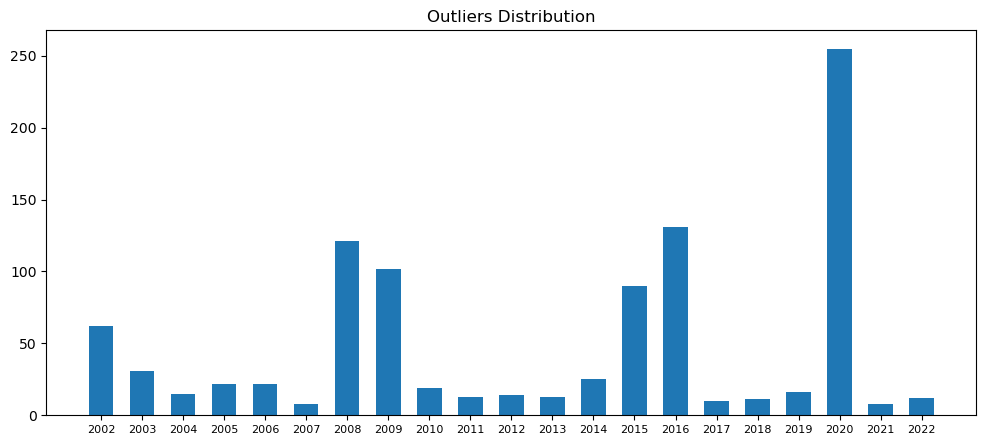

In [6]:
df_g = df.groupby('Year')['outliers'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.title('Outliers Distribution')
plt.bar(df_g['Year'], df_g['outliers'], width = 0.6)
plt.xticks([i for i in range(2002, 2023)], fontsize=8)
plt.show()

In [7]:
# filter out outliers
df = df[df['outliers'] == 0]

### Exploratory Analysis

In [8]:
df['Cusip'].nunique()

12472

In [9]:
# number of entries
# df['RatingClass'].value_counts(dropna=False)

In [10]:
# number of distinct Cusips
# df.groupby('RatingClass', dropna=False).Cusip.nunique()

In [11]:
# drop NR
# df = df.dropna(subset=['RatingNum'])

# number of entries
# df['MaturityBand'].value_counts(dropna=False)

In [12]:
# number of distinct Cusips
# df.groupby('MaturityBand').Cusip.nunique()

In [13]:
# df['Cusip'].nunique()

In [14]:
# filtering
# df = df[df['MaturityBand'] == 1]
# df = df[df['RatingClass'] == '1.HY']

In [15]:
get_sample_particulars(df)

Number of observations: 99,085
Returns: Mean: -0.13674 | Median: -0.08068 | Std returns: 0.02550
Volume mean: 100000.00000
Coupon mean: 4.70234


### Portfolio Analysis

In [16]:
# fill NULL returns
df['R'] = df['R'].fillna(0)

# log returns
df['logR'] = np.log(1 + df['R'])

In [17]:
J = 6 # formation period

df_ = df[
    ['Cusip', 'Date', 'R', 'logR']
].sort_values(['Cusip', 'Date']).set_index('Date')

cumr = df_.groupby(['Cusip'])['logR'].rolling(J, min_periods=J).sum().reset_index()
cumr = cumr.rename(columns = {'logR': 'SumLogR'})

cumr['CumRet'] = np.exp(cumr['SumLogR'])-1

In [18]:
r = 10 # momentum ranking

cumr = cumr.dropna(axis=0, subset=['CumRet'])

cumr['MomR'] = cumr.groupby('Date')['CumRet'].transform(lambda x: pd.qcut(x, r, labels=False))
cumr['MomR'] = 1 + cumr['MomR'].astype(int)

In [19]:
cumr.groupby('MomR')['CumRet'].mean()

MomR
1    -0.098782
2    -0.041831
3    -0.025318
4    -0.015284
5    -0.007096
6     0.000907
7     0.010141
8     0.022205
9     0.041000
10    0.097089
Name: CumRet, dtype: float64

In [20]:
K = 1 # Holding Period Length: K can be between 3 to 12 months

cumr['form_date'] = cumr['Date']
cumr['medate'] = cumr['Date'] + MonthEnd(0)
cumr['hdate1'] = cumr['medate'] + MonthBegin(1)
cumr['hdate2'] = cumr['medate'] + MonthEnd(K)
cumr = cumr[['Cusip', 'form_date','MomR','hdate1','hdate2']]

port = pd.merge(df[['Cusip', 'Date', 'R']], cumr, on=['Cusip'], how='inner')
port = port[(port['hdate1'] <= port['Date']) & (port['Date'] <= port['hdate2'])]
port = port[['Cusip','form_date', 'MomR', 'hdate1','hdate2', 'Date', 'R']]
port['Date'] = pd.to_datetime(port['Date'])

In [21]:
cumr_port = port.groupby(['Date','MomR', 'form_date'])['R'].mean().reset_index()

start_yr = cumr_port['Date'].dt.year.min() + 2
cumr_port = cumr_port.loc[cumr_port.Date.dt.year >= start_yr]
cumr_port = cumr_port.sort_values(by=['Date','MomR'])

ewret = cumr_port.groupby(['Date','MomR'])['R'].mean().reset_index()
ewstd = cumr_port.groupby(['Date','MomR'])['R'].std().reset_index()

ewret = ewret.rename(columns={'R':'ewret'})
ewstd = ewstd.rename(columns={'R':'ewretstd'})

ewretdf = pd.merge(ewret, ewstd, on=['Date','MomR'], how='inner')
ewretdf = ewretdf.sort_values(by=['MomR', 'Date'])

In [23]:
ewretdf.groupby(['MomR'])['ewret'].describe()[['count','mean', 'std']].reset_index()

,MomR,count,mean,std
0,1,213.0,-0.000020,0.028061
1,2,213.0,-0.001170,0.017889
2,3,213.0,-0.001122,0.012751
3,4,213.0,-0.001306,0.011836
4,5,213.0,-0.001159,0.009891
5,6,212.0,-0.001676,0.009861
6,7,213.0,-0.000909,0.010775
7,8,213.0,-0.000648,0.011480
8,9,213.0,0.000406,0.013688
9,10,213.0,-0.000026,0.020525


In [24]:
ewret_t = ewretdf.pivot(index='Date', columns='MomR', values='ewret') 

# Add prefix port in front of each column 
ewret_t = ewret_t.add_prefix('port') 
ewret_t = ewret_t.rename(columns={'port1':'losers', 'port10':'winners'}) 
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers
ewret_t.head()

MomR,losers,port2,port3,port4,port5,port6,port7,port8,port9,winners,long_short
Date,,,,,,,,,,,
2005-01-31,-0.013670,-0.018183,-0.005596,-0.002030,-0.011314,-0.009382,-0.006124,-0.010084,-0.004343,-0.004728,0.008942
2005-02-28,0.019880,-0.002012,-0.003105,-0.000660,-0.010230,-0.006354,-0.007263,-0.006908,0.005281,-0.000751,-0.020631
2005-03-31,-0.059758,-0.042003,-0.018343,-0.022955,-0.011895,-0.019125,-0.012692,-0.031139,-0.028216,-0.014144,0.045614
2005-04-30,-0.054613,-0.021451,-0.000337,-0.001453,0.001019,0.004896,0.010388,-0.014810,0.002259,0.006126,0.060739
2005-05-31,0.011785,-0.012457,-0.003802,0.002517,-0.002208,-0.002869,0.001173,-0.000066,0.008710,0.010600,-0.001185


In [25]:
ewret_t['cumret_winners'] = (1 + ewret_t.winners).cumprod() - 1 
ewret_t['cumret_losers'] = (1 + ewret_t.losers).cumprod() - 1
ewret_t['cumret_long_short'] = (1 + ewret_t.long_short).cumprod() - 1

mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()
mom_mean

,MomR,mean
0,winners,-0.000026
1,losers,-0.000020
2,long_short,-0.000005


In [26]:
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'], 0.0, nan_policy='omit')).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'], 0.0, nan_policy='omit')).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'], 0.0, nan_policy='omit')).to_frame().T

t_losers['MomR'] = 'losers'
t_winners['MomR'] = 'winners'
t_long_short['MomR'] = 'long_short'

In [27]:
t_output = pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0:'t-stat', 1:'p-value'}) 

# Combine mean, t and p and format output 
mom_output = pd.merge(mom_mean, t_output, on=['MomR'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format) 
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format) 
mom_output['p-value'] = mom_output['p-value'].map('{:.2f}'.format) 

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          MomR    mean t-stat p-value
0     winners  -0.00%  -0.02    0.99
1      losers  -0.00%  -0.01    0.99
2  long_short  -0.00%  -0.00    1.00


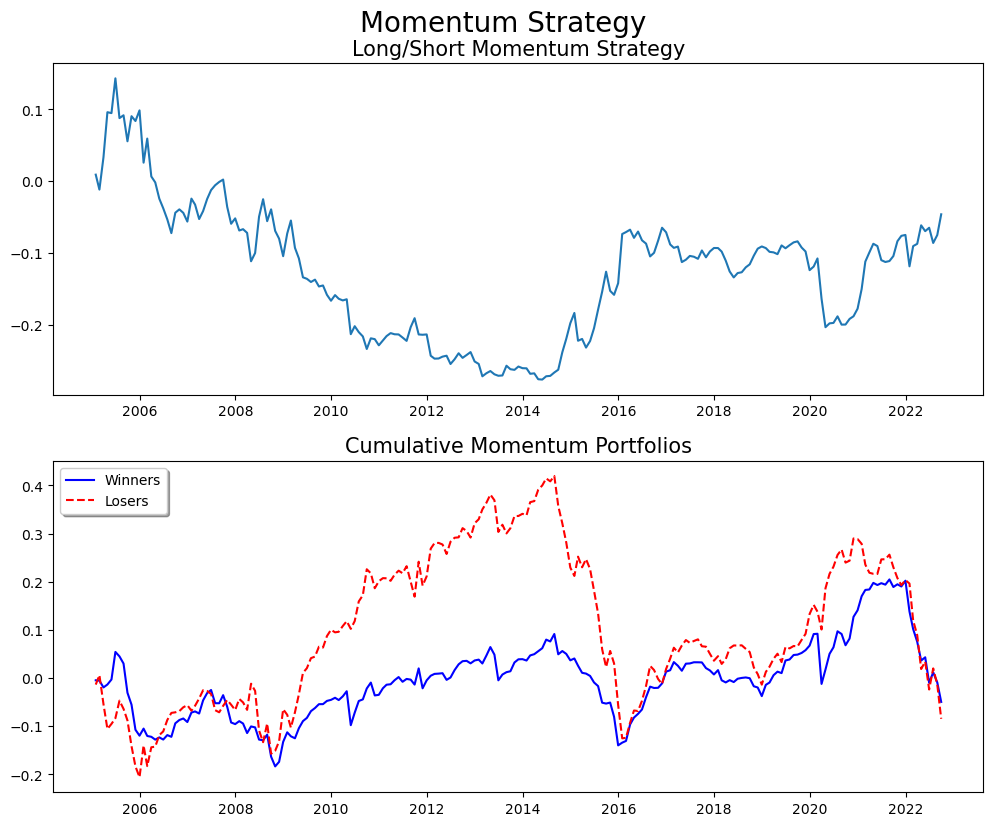

In [28]:
plt.figure(figsize=(12,9)) 
plt.suptitle('Momentum Strategy', fontsize=20) 

ax1 = plt.subplot(211) 
ax1.set_title('Long/Short Momentum Strategy', fontsize=15) 
ax1.plot(ewret_t['cumret_long_short']) 

ax2 = plt.subplot(212) 
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15) 
ax2.plot(ewret_t['cumret_winners'], 'b-', ewret_t['cumret_losers'], 'r--') 
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)